In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [2]:
# Model (system)
class System(torch.nn.Module):
    def __init__(self):
        super(System, self).__init__()
        self.input1 = torch.nn.Linear(1, 1, bias=False)
        self.input1.weight.data = torch.tensor([[1.0]])

        self.input2 = torch.nn.Linear(1, 1, bias=False)
        self.input2.weight.data = torch.tensor([[1.0]])

    def forward(self, y0, u):
        zy = self.input1(y0)
        zu = self.input2(u)
        return zy * zu

In [3]:
class MPC(torch.nn.Module):
    def __init__(self, T):
        super(MPC, self).__init__()
        self.u = torch.nn.Parameter(torch.ones(T))

    def forward(self, system, umin, umax, y0, yT, R, Q, U):
        u = self.u
        lu = torch.relu(umin-u).sum() + torch.relu(u-umax).sum()
        l1 = ((u[1:] - u[0:-1]).sum().expand(1))**2     # changing of input
        y1 = system(y0, u[0:1])                         # output 1
        l2 = (y1-yT)**2                                 # SE of output with reference yT
        for i in range(list(u.shape)[0] - 1):
            y2 = system(y1, u[i+1:i+2])
            l2 = l2 + (y2-yT)**2
            y1 = y2
        return R*l1 + Q*l2 + U*lu

In [4]:
# Train function
loss_function = torch.nn.MSELoss()
def train(system, mpc, umin, umax, y0, yT, R, Q, U, epochs, _lr):
    opt = torch.optim.Adam(mpc.parameters(), lr=_lr)
    for epoch in range(epochs+1):
        opt.zero_grad()
        loss = loss_function(mpc(system, umin, umax, y0, yT, R, Q, U), torch.tensor([0.]))
        loss.backward(retain_graph=True)
        opt.step()

In [5]:
# parameter for MPC
N  = 40                             # prediction horizon length
T  = 20                             # control horizon length
y0 = torch.tensor([1.])             # y0
yT = torch.tensor([20.])            # yT
umin = 0                            # u min
umax = 1.5                          # u max
R = 1                               # input change penalty
Q = 1                               # reference difference penalty
U = 1e9                             # input violation penalty

In [6]:
# plant
system = System()

# model
mpc = MPC(T)

# Train MPC
u_vector = np.zeros(N+1)
y_vector = np.zeros(N+1)
y_vector[0] = y0.detach().numpy()[0]

for i in range(N):
    train(system, mpc, umin, umax, y0, yT, R, Q, U, epochs=200, _lr=0.01)
    u = mpc.u
    y0 = system(y0, u[0:1]).data
    u_vector[1+i] = u.detach().numpy()[0]
    y_vector[1+i] = y0.detach().numpy()[0]

    print("u = %5.3f \t y = %5.3f" % (u.detach().numpy()[0], y0.detach().numpy()[0]))

u = 1.390 	 y = 1.390
u = 1.429 	 y = 1.986
u = 1.431 	 y = 2.842
u = 1.442 	 y = 4.098
u = 1.390 	 y = 5.698
u = 1.405 	 y = 8.006
u = 1.353 	 y = 10.835
u = 1.295 	 y = 14.036
u = 1.220 	 y = 17.123
u = 1.135 	 y = 19.436
u = 1.054 	 y = 20.485
u = 0.998 	 y = 20.440
u = 0.996 	 y = 20.352
u = 0.995 	 y = 20.255
u = 0.996 	 y = 20.170
u = 0.997 	 y = 20.107
u = 0.998 	 y = 20.066
u = 0.999 	 y = 20.042
u = 0.999 	 y = 20.032
u = 1.000 	 y = 20.030
u = 1.004 	 y = 20.113
u = 1.001 	 y = 20.139
u = 1.000 	 y = 20.132
u = 0.987 	 y = 19.867
u = 0.993 	 y = 19.733
u = 0.998 	 y = 19.693
u = 1.001 	 y = 19.711
u = 1.015 	 y = 20.006
u = 1.008 	 y = 20.165
u = 1.003 	 y = 20.226
u = 1.000 	 y = 20.223
u = 0.986 	 y = 19.945
u = 0.992 	 y = 19.793
u = 0.997 	 y = 19.735
u = 1.000 	 y = 19.737
u = 1.002 	 y = 19.773
u = 1.008 	 y = 19.936
u = 1.005 	 y = 20.040
u = 1.003 	 y = 20.092
u = 1.001 	 y = 20.106


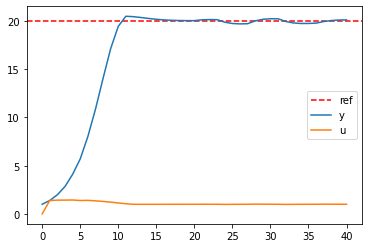

In [7]:
# Plot
plt.axhline(y = yT.detach().numpy()[0], color = 'r', linestyle = '--', label='ref')
plt.plot(y_vector, label='y')
plt.plot(u_vector, label='u')
plt.legend()
plt.show()